In [13]:
import keras
import math
import glob
import os   # 处理字符串路径
from keras.preprocessing.image import array_to_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras import metrics
from keras import backend as K

from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

from PIL import Image
from PIL import ImageOps
from PIL import ImageFilter
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import numpy as np
import matplotlib.pyplot as plt
import cv2


In [ ]:
#img1 = cv2.imread('match/pad_01.jpg', cv2.IMREAD_GRAYSCALE)
#plt.imshow(img1, cmap = 'gray')


In [14]:

img_width, img_height, img_channel = 224, 224, 3
num_classes = 2

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, img_channel))

base_model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [15]:

x = Flatten()(base_model.output)

x = Dense(512)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.75)(x)

x = Dense(num_classes, activation='softmax', name='predictions')(x)

model = Model(inputs=base_model.input, outputs=x)

for layer in base_model.layers[:15]:
    layer.trainable = False

model.compile(optimizer=keras.optimizers.SGD(lr=0.0001, momentum=0.9, decay=0, nesterov=True), 
              loss='categorical_crossentropy', metrics=['accuracy',metrics.mae, metrics.categorical_accuracy])

"""
model.compile(optimizer=keras.optimizers.RMSprop(), 
              loss='categorical_crossentropy', metrics=['accuracy',metrics.mae, metrics.categorical_accuracy])

model.compile(optimizer=keras.optimizers.Adagrad(), 
              loss='categorical_crossentropy', metrics=['accuracy',metrics.mae, metrics.categorical_accuracy])

model.compile(optimizer=keras.optimizers.Adam(), 
              loss='categorical_crossentropy', metrics=['accuracy',metrics.mae, metrics.categorical_accuracy])
"""
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [16]:
train_data_dir = 'data_call/train'
validation_data_dir = 'data_call/val'

nb_train_samples = 748
nb_validation_samples = 196
epochs = 40
batch_size = 32

In [17]:
train_datagen = ImageDataGenerator(
#    samplewise_center = True,
    rotation_range=10,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip= True,
  #  vertical_flip=True,
    rescale=1. / 255
    )

# this is the augmentation configuration we will use for testing:
# only rescaling
validation_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')


Found 748 images belonging to 2 classes.
Found 196 images belonging to 2 classes.


In [18]:
def step_decay(epoch):
    initial_lrate = 0.0001
    drop = 0.5
    epochs_drop = 2
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    print("current lrate")
    print(lrate)
    return lrate

In [19]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.acc = []
        self.val_losses = []
        self.val_acc = []
        

    def on_batch_end(self, batch, logs={}):
     #  print(logs.get('loss'))
     #   print(logs.get('acc'))
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('acc'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_acc.append(logs.get('val_acc'))
        plt.plot(self.acc,'r--')
        plt.plot(self.losses,'b')
        plt.plot(self.val_acc,'g--')
        plt.plot(self.val_losses,'y')
      #  plt.show()

In [20]:
batch_parms = LossHistory()

plot_loss_callback = keras.callbacks.LambdaCallback(
    on_battch_end=lambda batch, logs: plt.plot(np.arange(batch),
                      logs['loss']))

callbacks = [
   #EarlyStopping(monitor='val_loss', patience= 3, verbose=0),
    keras.callbacks.ModelCheckpoint('cervical_best.hdf5', monitor='val_loss', save_best_only=True, verbose=0),
  #  LearningRateScheduler(step_decay)
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, verbose=1, mode='auto', epsilon=0.0001, cooldown=1, min_lr=0),
  #  keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)
    keras.callbacks.TensorBoard(log_dir='./logs'),
  # batch_parms
  # plot_loss_callback
]

d:\new py\lib\site-packages\keras\callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [21]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=40,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    verbose=1,   
    #callbacks=None)
    callbacks=callbacks)
#callbacks=[batch_parms])

with open('history.txt','w') as f:
    f.write(str(history.history))
    
model.save_weights('training_calling.h5')
model.save("vgg16_classification_calling.h5")


Epoch 1/40
23/23 [==============================] - 307s 13s/step - loss: 1.0436 - acc: 0.5815 - mean_absolute_error: 0.4311 - categorical_accuracy: 0.5815 - val_loss: 0.4445 - val_acc: 0.7188 - val_mean_absolute_error: 0.3158 - val_categorical_accuracy: 0.7188
Epoch 2/40
23/23 [==============================] - 282s 12s/step - loss: 0.7457 - acc: 0.6850 - mean_absolute_error: 0.3464 - categorical_accuracy: 0.6850 - val_loss: 0.2642 - val_acc: 0.9085 - val_mean_absolute_error: 0.1977 - val_categorical_accuracy: 0.9085
Epoch 3/40
23/23 [==============================] - 284s 12s/step - loss: 0.4858 - acc: 0.7962 - mean_absolute_error: 0.2468 - categorical_accuracy: 0.7962 - val_loss: 0.1601 - val_acc: 0.9695 - val_mean_absolute_error: 0.1228 - val_categorical_accuracy: 0.9695
Epoch 4/40
23/23 [==============================] - 285s 12s/step - loss: 0.4195 - acc: 0.8303 - mean_absolute_error: 0.2029 - categorical_accuracy: 0.8303 - val_loss: 0.1390 - val_acc: 0.9817 - val_mean_absolute_e

23/23 [==============================] - 289s 13s/step - loss: 0.1193 - acc: 0.9578 - mean_absolute_error: 0.0704 - categorical_accuracy: 0.9578 - val_loss: 0.0058 - val_acc: 1.0000 - val_mean_absolute_error: 0.0047 - val_categorical_accuracy: 1.0000

Epoch 00027: ReduceLROnPlateau reducing learning rate to 1.5258788677030566e-09.
Epoch 28/40
23/23 [==============================] - 278s 12s/step - loss: 0.1282 - acc: 0.9469 - mean_absolute_error: 0.0711 - categorical_accuracy: 0.9469 - val_loss: 0.0124 - val_acc: 0.9939 - val_mean_absolute_error: 0.0083 - val_categorical_accuracy: 0.9939

Epoch 00028: ReduceLROnPlateau reducing learning rate to 7.629394338515283e-10.
Epoch 29/40
23/23 [==============================] - 285s 12s/step - loss: 0.0762 - acc: 0.9687 - mean_absolute_error: 0.0527 - categorical_accuracy: 0.9687 - val_loss: 0.0111 - val_acc: 0.9948 - val_mean_absolute_error: 0.0076 - val_categorical_accuracy: 0.9948

Epoch 00029: ReduceLROnPlateau reducing learning rate to 3.

In [73]:
""""
test_datagen = ImageDataGenerator(
#    samplewise_center = True,
    preprocessing_function=img_Gaussianblur
    )

test_generator = test_datagen.flow_from_directory(
        'data/train/P_NG',
        target_size=(128, 128),
        batch_size=32,
        class_mode=None,  # only data, no labels
        shuffle=False)  # keep data in same order as labels

probabilities = model.predict_generator(test_generator, 1247/32)

print(probabilities)

from keras.models import load_model
model = load_model('cervical_best.hdf5')

files = glob.glob("data/train/P_NG/*")
image_list = [] 
for f in files:
    print (f)
    image = cv2.imread(f)
    image = cv2.resize(image,(128,128))
    image_list.append(image)
        
image_list = np.array(image_list)
predictions = model.predict(image_list, verbose=1, batch_size=32)


NameError: name 'img_Gaussianblur' is not defined

SyntaxError: invalid character in identifier (<ipython-input-24-0932c83177ed>, line 18)

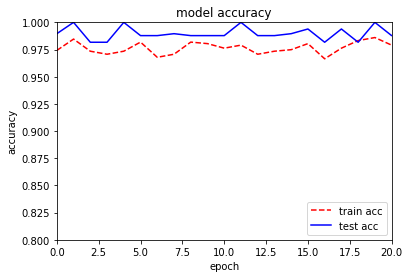

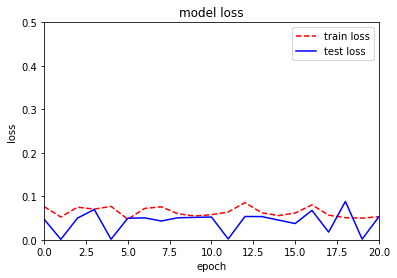

In [19]:

# summarize history for accuracy
plt.ylim(0.8,1)
plt.xlim(0,20)
plt.plot(history.history['acc'],'r--')
plt.plot(history.history['val_acc'],'b-')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train acc', 'test acc'], loc='lower right')
plt.savefig("acc.png")
plt.show()
# summarize history for loss
plt.ylim(0,0.5)
plt.xlim(0,20)
plt.plot(history.history['loss'],'r--')
plt.plot(history.history['val_loss'],'b-')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'test loss'], loc='upper right')
plt.savefig("loss.png")


In [134]:
""""
def predict(url):
    im = load_image(url) 
    if  np.all(im ==None):  
        pass
    else:
        im = cv2.resize(im,(128,128))
    im = image/ 255.
    out =model.predict(im, verbose=1, batch_size=32)
    flbase = os.path.basename(url)
    p = np.sum(out) / (np.sum(out) + np.sum(out))
    result.append((flbase,p))

In [182]:
""""
def predict(url):
    im = cv2.imread(url) 
    im=im/255.
    im = cv2.resize(im,(128,128)).astype(np.float32)
    #im[:,:,0] -= 103.939
    #im[:,:,1] -= 116.779
    #im[:,:,2] -= 123.68
    #im = im.transpose((2,0,1))
    im = np.expand_dims(im,axis=0)
    #im = np.array(im)
    out = model.predict(im, verbose=1, batch_size=32)
    np.set_printoptions(precision=3)
    flbase = os.path.basename(url)
   # p = np.sum(out[0,dogs]) #/ (np.sum(out[0,dogs]) + np.sum(out[0,cats]))
    result.append((flbase,out))

In [183]:

# files = glob.glob("pad_data/test/*jpg")
# i=0
# for fl in files:
#     a=cv2.imread(fl)
#     print (f)
#     i=i+1
#     if  np.all(a ==None):  
#         pass
#     else:
#         predict(fl)
#         print(out)
# print(i)

pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 103ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 96ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 99ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 97ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 104ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 99ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 103ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 101ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [

[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 102ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 97ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 94ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 97ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 98ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 97ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 96ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 98ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jp

[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 101ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 99ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 98ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 96ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 99ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 100ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 101ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 100ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7

1/1 [==============================] - 0s 121ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 110ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 105ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 107ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 105ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 114ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 131ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 138ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 105ms/step
[[0

[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 109ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 102ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 102ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 100ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 102ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 102ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 100ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 101ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b

[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 106ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 101ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 117ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 107ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 105ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 101ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 104ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 105ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b

1/1 [==============================] - 0s 108ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 108ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 110ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 111ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 107ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 99ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 106ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 102ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 102ms/step
[[0.

1/1 [==============================] - 0s 109ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 100ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 102ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 101ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 102ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 100ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 99ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 99ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 100ms/step
[[0. 

1/1 [==============================] - 0s 107ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 100ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 107ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 103ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 101ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 102ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 102ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 101ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 100ms/step
[[0

[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 102ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 98ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 117ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 107ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 106ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 112ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 100ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 102ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b1

1/1 [==============================] - 0s 103ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 101ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 101ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 99ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 101ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 99ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 100ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 105ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 100ms/step
[[0. 

[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 101ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 104ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 106ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 104ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 102ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 103ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 104ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 100ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b

1/1 [==============================] - 0s 114ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 106ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 106ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 102ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 121ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 100ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 96ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 97ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 98ms/step
[[0. 1

1/1 [==============================] - 0s 105ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 101ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 101ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 101ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 98ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 95ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 99ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 105ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 100ms/step
[[0. 1

1/1 [==============================] - 0s 106ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 100ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 99ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 101ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 103ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 104ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 100ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 102ms/step
[[0. 1.]]
pad_data/test\ffc391e7-dc94-454b-849a-ea94b85b14a7.jpg
1/1 [==============================] - 0s 104ms/step
[[0.

In [18]:
#files = glob.glob("validation/P_NG/*")
files = glob.glob("data_call/test/*bmp")
image_list = [] 
for f in files:
    print (f)
    image = cv2.imread(f)
    if  np.all(image ==None):  
        pass
    else:
        image = cv2.resize(image,(128,128))
        image = image/ 255.
        image = np.expand_dims(image,axis=0)
       # image_list.append(image)
        pre=model.predict(image, verbose=1, batch_size=32)
        #pre.append(f)
        print(pre)
        if pre[0][0]>pre[0][1]:
           image_list.append(f)
            
# image_list = np.array(image_list)
# predictions = model.predict(image_list, verbose=1, batch_size=32)
print(image_list)


data_call/test\eye_closed_01.avi0000.bmp
1/1 [==============================] - 0s 100ms/step
[[5.4521583e-06 9.9999452e-01]]
data_call/test\eye_closed_01.avi0001.bmp
1/1 [==============================] - 0s 97ms/step
[[2.1926540e-05 9.9997807e-01]]
data_call/test\eye_closed_01.avi0011.bmp
1/1 [==============================] - 0s 98ms/step
[[1.3403029e-05 9.9998665e-01]]
data_call/test\eye_closed_01.avi0012.bmp
1/1 [==============================] - 0s 95ms/step
[[1.08986915e-05 9.99989152e-01]]
data_call/test\eye_closed_01.avi0022.bmp
1/1 [==============================] - 0s 98ms/step
[[9.237538e-06 9.999908e-01]]
data_call/test\eye_closed_01.avi0023.bmp
1/1 [==============================] - 0s 98ms/step
[[7.467683e-06 9.999925e-01]]
data_call/test\eye_closed_02.avi0033.bmp
1/1 [==============================] - 0s 96ms/step
[[9.7631862e-05 9.9990237e-01]]
data_call/test\eye_closed_02.avi0034.bmp
1/1 [==============================] - 0s 99ms/step
[[9.724310e-05 9.999027e-01]]
dat

1/1 [==============================] - 0s 106ms/step
[[2.1825006e-05 9.9997818e-01]]
data_call/test\look_sideway_04.avi0365.bmp
1/1 [==============================] - 0s 103ms/step
[[2.2789780e-05 9.9997723e-01]]
data_call/test\look_sideway_04.avi0366.bmp
1/1 [==============================] - 0s 110ms/step
[[2.2645341e-05 9.9997735e-01]]
data_call/test\look_sideway_04.avi0376.bmp
1/1 [==============================] - 0s 105ms/step
[[2.6299565e-05 9.9997365e-01]]
data_call/test\look_sideway_04.avi0377.bmp
1/1 [==============================] - 0s 100ms/step
[[2.4878482e-05 9.9997509e-01]]
data_call/test\Phoning_01.avi0000.bmp
1/1 [==============================] - 0s 100ms/step
[[9.9967945e-01 3.2052587e-04]]
data_call/test\Phoning_01.avi0001.bmp
1/1 [==============================] - 0s 104ms/step
[[9.9935395e-01 6.4600434e-04]]
data_call/test\Phoning_01.avi0002.bmp
1/1 [==============================] - 0s 97ms/step
[[9.995396e-01 4.603972e-04]]
data_call/test\Phoning_01.avi0003.bmp

[[9.9986172e-01 1.3824788e-04]]
data_call/test\Phoning_05.avi0207.bmp
1/1 [==============================] - 0s 96ms/step
[[9.997999e-01 2.001100e-04]]
data_call/test\Phoning_05.avi0208.bmp
1/1 [==============================] - 0s 98ms/step
[[9.9982244e-01 1.7762485e-04]]
data_call/test\Phoning_05.avi0209.bmp
1/1 [==============================] - 0s 96ms/step
[[9.9980420e-01 1.9579209e-04]]
data_call/test\Phoning_05.avi0210.bmp
1/1 [==============================] - 0s 109ms/step
[[9.9982220e-01 1.7785213e-04]]
data_call/test\Phoning_07.avi0300.bmp
1/1 [==============================] - 0s 95ms/step
[[9.9998605e-01 1.3896245e-05]]
data_call/test\Phoning_07.avi0301.bmp
1/1 [==============================] - 0s 115ms/step
[[9.9998963e-01 1.0416245e-05]]
data_call/test\Phoning_07.avi0302.bmp
1/1 [==============================] - 0s 92ms/step
[[9.9999452e-01 5.4788666e-06]]
data_call/test\Phoning_07.avi0303.bmp
1/1 [==============================] - 0s 98ms/step
[[9.9999380e-01 6.209785

[[4.1053190e-06 9.9999595e-01]]
data_call/test\yawn_03.avi0509.bmp
1/1 [==============================] - 0s 97ms/step
[[4.3111627e-06 9.9999571e-01]]
data_call/test\yawn_04.avi0519.bmp
1/1 [==============================] - 0s 96ms/step
[[4.9039536e-06 9.9999511e-01]]
data_call/test\yawn_04.avi0520.bmp
1/1 [==============================] - 0s 100ms/step
[[9.174999e-06 9.999908e-01]]
data_call/test\yawn_04.avi0530.bmp
1/1 [==============================] - 0s 95ms/step
[[2.2539185e-04 9.9977463e-01]]
data_call/test\yawn_04.avi0531.bmp
1/1 [==============================] - 0s 97ms/step
[[3.5107043e-04 9.9964893e-01]]
data_call/test\yawn_04.avi0541.bmp
1/1 [==============================] - 0s 100ms/step
[[8.3961044e-05 9.9991608e-01]]
data_call/test\yawn_04.avi0542.bmp
1/1 [==============================] - 0s 96ms/step
[[7.1810609e-05 9.9992824e-01]]
data_call/test\yawn_04.avi0552.bmp
1/1 [==============================] - 0s 97ms/step
[[1.698941e-04 9.998301e-01]]
data_call/test\yaw